In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

Using KDE based trigger function.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.grid_nonparam

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import opencrimedata.chicago
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
northside = open_cp.sources.chicago.get_side("South")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

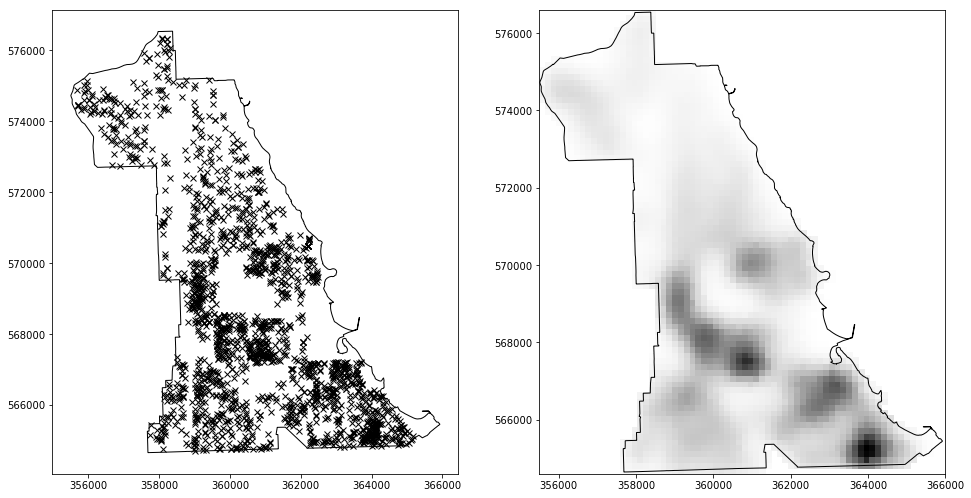

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(1))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

ExpDecayModel(T=364.4583333333333, theta=0.00943296006828683, f=<open_cp.kernels.Reflect1D object at 0x0000027266128B38>

In [9]:
def plot(model, trigger_limit=20):
    fig, axes = plt.subplots(ncols=2, figsize=(16,6))

    ax = axes[0]
    pred = trainer.prediction_from_background(model)
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    fig.colorbar(mappable, ax=ax)
    ax.set_title("Estimated background rate")

    ax = axes[1]
    x = np.linspace(0, trigger_limit, 200)
    x = x * (trainer.time_unit / np.timedelta64(1,"D"))
    ax.plot(x, model.trigger_func(x) * model.theta)
    ax.set(xlabel="Days", ylabel="Rate", title="Trigger kernel")
    
    return fig

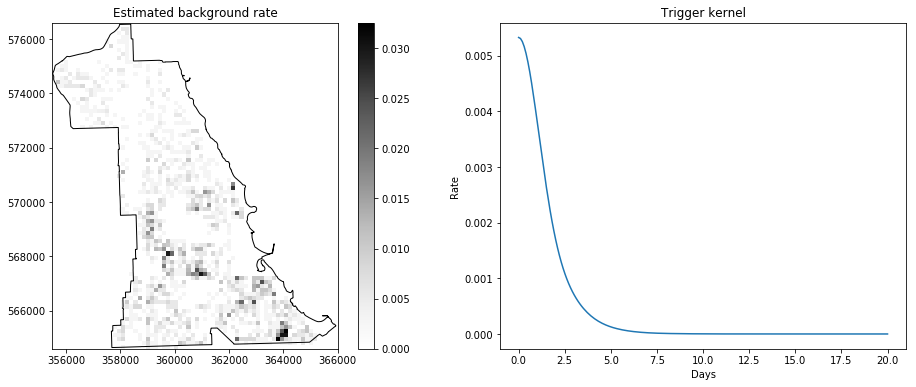

In [10]:
fig = plot(model)

In [11]:
np.max(model.mu), np.min(model.mu)

(0.032532316069654559, 0.0)

## Investigate different initial conditions

It doesn't seem to really matter!  Which is good!

In [12]:
cells, modeli = trainer.initial_model(datetime.datetime(2017,1,1))

In [13]:
def func(t):
    return np.exp(-t / 100)

In [14]:
model = sepp.grid_nonparam.KDEModel(modeli.mu, modeli.T, modeli.theta, func)
model

ExpDecayModel(T=364.4583333333333, theta=0.5, f=<function func at 0x00000272693F1F28>

In [15]:
for _ in range(50):
    opt = trainer.provider.make_opt(model, cells)
    model = opt.optimised_model()

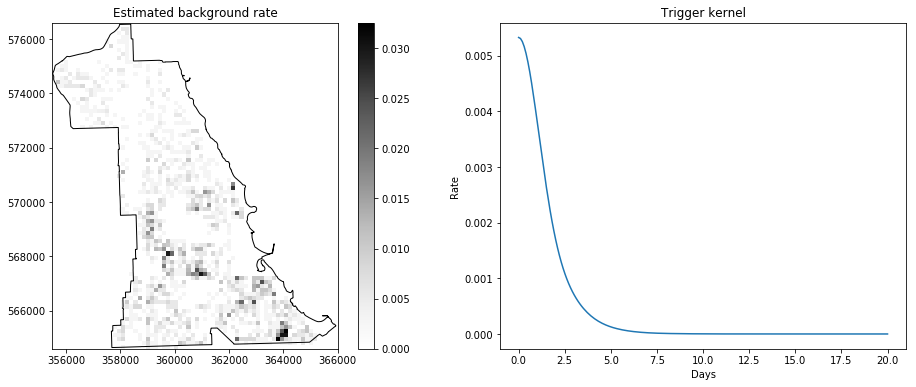

In [16]:
fig = plot(model)

# Vary the bandwidth

In [17]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.05))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

ExpDecayModel(T=364.4583333333333, theta=0.02630694293015054, f=<open_cp.kernels.Reflect1D object at 0x0000027269B8C8D0>

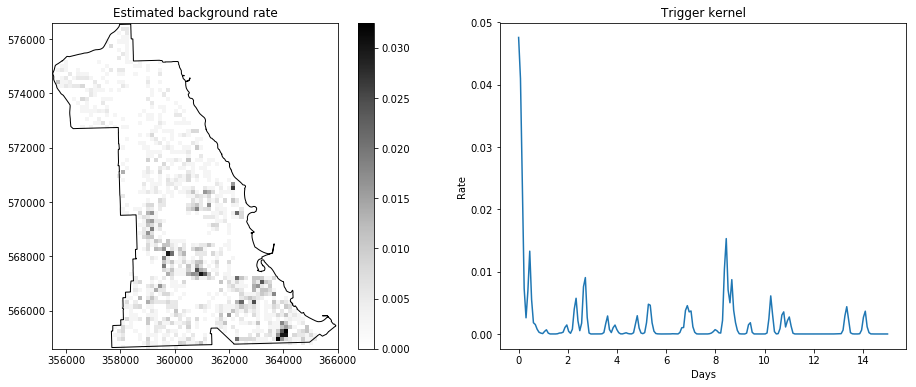

In [18]:
fig = plot(model, 15)

In [19]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.1))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

ExpDecayModel(T=364.4583333333333, theta=0.015127943664944845, f=<open_cp.kernels.Reflect1D object at 0x0000027266391668>

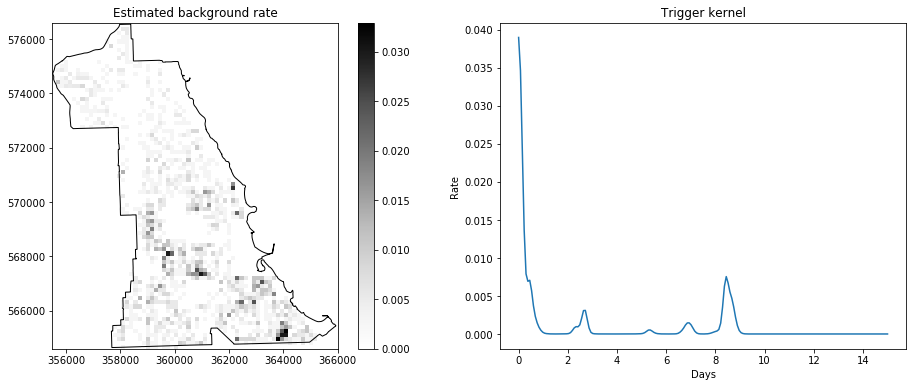

In [20]:
fig = plot(model, 15)

In [21]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.2))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

ExpDecayModel(T=364.4583333333333, theta=0.012400362272252781, f=<open_cp.kernels.Reflect1D object at 0x000002726A6B8518>

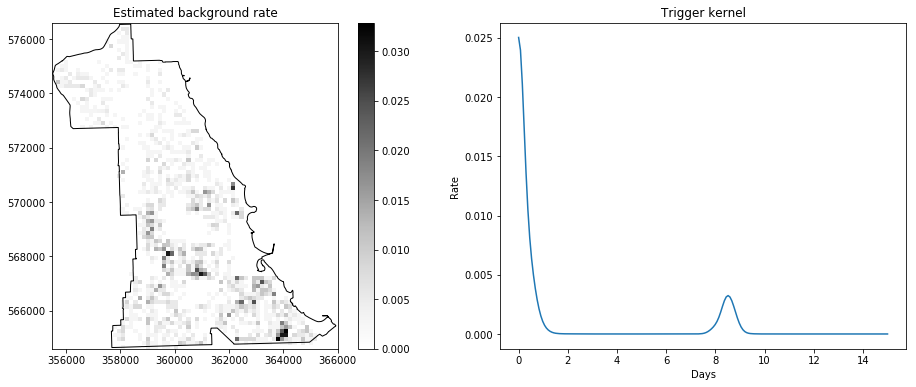

In [22]:
fig = plot(model, 15)

ExpDecayModel(T=364.4583333333333, theta=0.010452531991115864, f=<open_cp.kernels.Reflect1D object at 0x0000027268CC23C8>

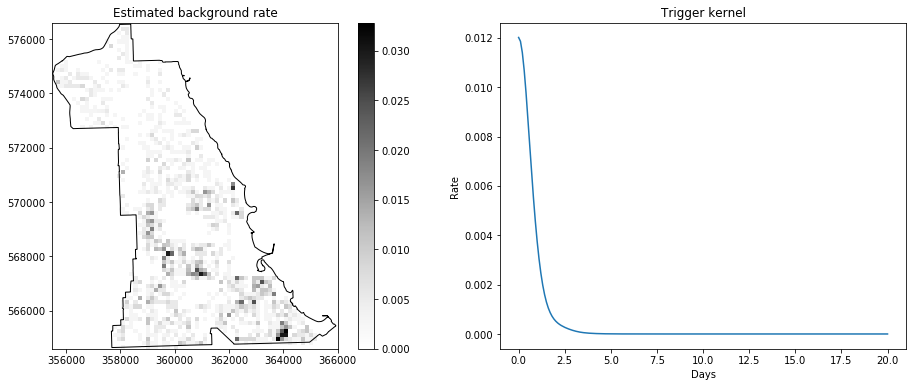

In [23]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.5))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
plot(model)
model

ExpDecayModel(T=364.4583333333333, theta=0.002773688534921975, f=<open_cp.kernels.Reflect1D object at 0x000002726994CCC0>

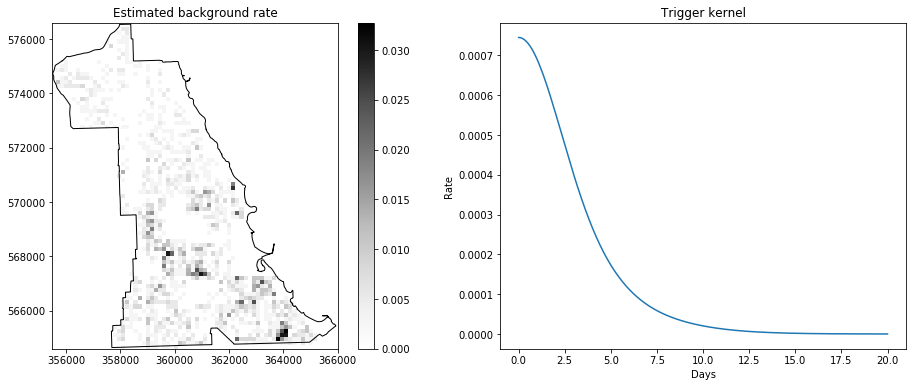

In [24]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(2))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
plot(model)
model

# Use a variable bandwidth KDE

ExpDecayModel(T=364.4583333333333, theta=0.0164152908501571, f=<open_cp.kernels.Reflect1D object at 0x0000027269A5EE80>

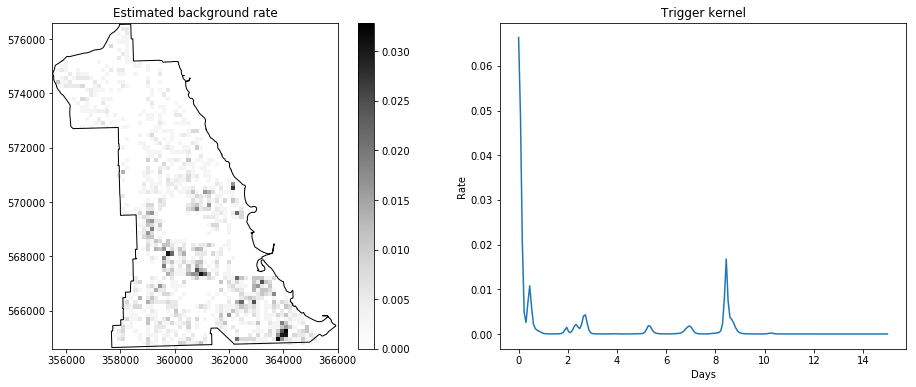

In [25]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(5))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
_ = plot(model, 15)
model

ExpDecayModel(T=364.4583333333333, theta=0.01006560841257302, f=<open_cp.kernels.Reflect1D object at 0x000002726960ABA8>

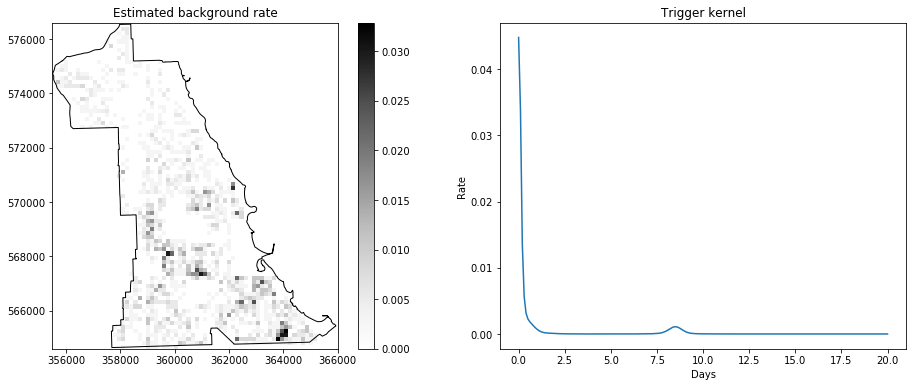

In [26]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(15))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
_ = plot(model)
model

ExpDecayModel(T=364.4583333333333, theta=0.010573784340924201, f=<open_cp.kernels.Reflect1D object at 0x000002726993C0F0>

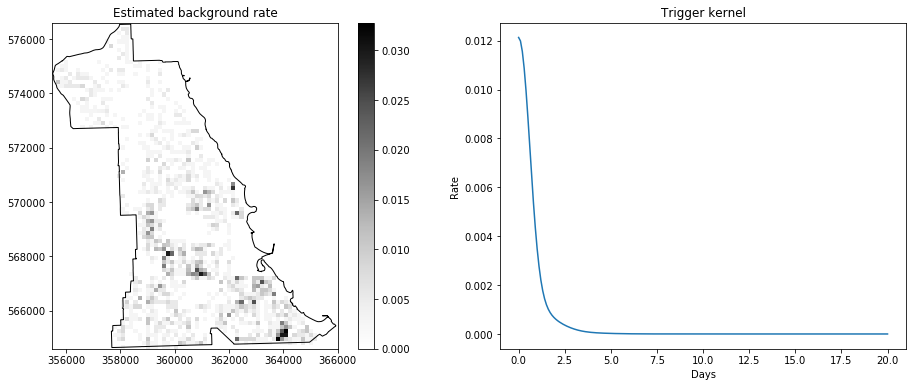

In [27]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(30))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
_ = plot(model)
model

ExpDecayModel(T=364.4583333333333, theta=0.006665770086516643, f=<open_cp.kernels.Reflect1D object at 0x00000272698F1D30>

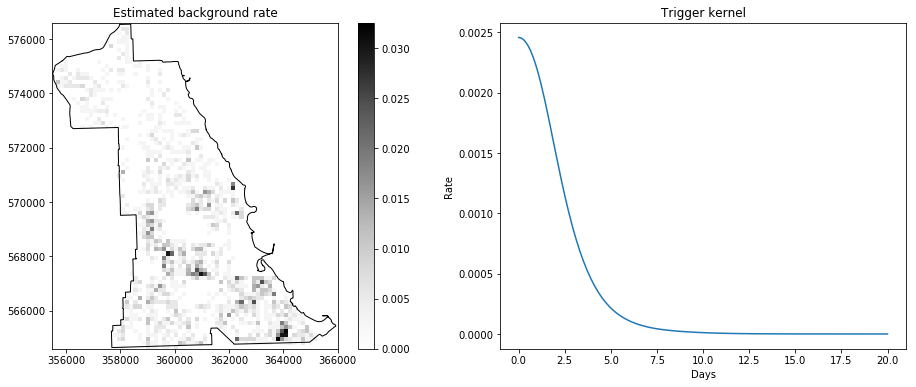

In [28]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(50))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
_ = plot(model)
model

ExpDecayModel(T=364.4583333333333, theta=8.43569179815158e-06, f=<open_cp.kernels.Reflect1D object at 0x0000027268AC6198>

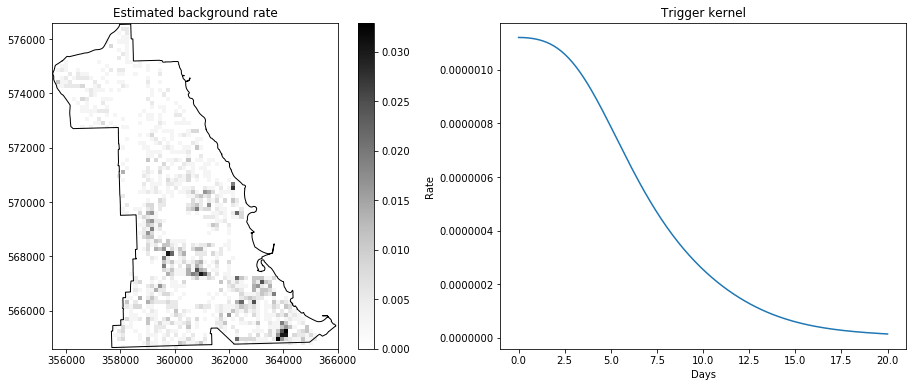

In [29]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(100))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
_ = plot(model)
model

# Summary plots for article

In [30]:
bandwidths = [0.05, 0.1, 1, 2]

models = {}
for bw in bandwidths:
    trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(bw))
    trainer.data = points
    models[bw] = trainer.train(datetime.datetime(2017,1,1), iterations=50)

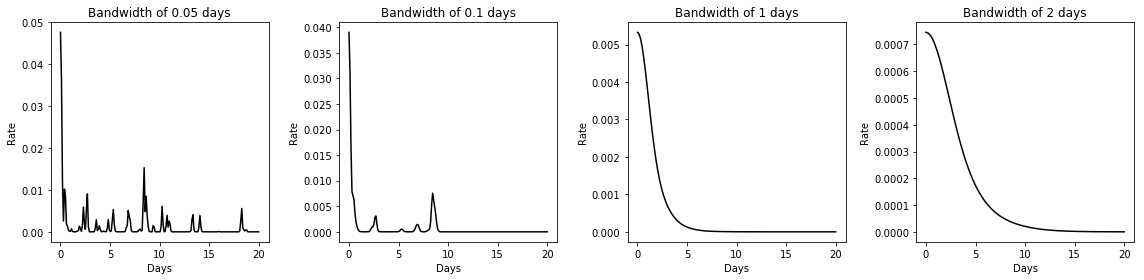

In [31]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, bw in zip(axes, models):
    model = models[bw]

    x = np.linspace(0, 20, 200)
    x = x * (trainer.time_unit / np.timedelta64(1,"D"))
    ax.plot(x, model.trigger_func(x) * model.theta, color="black")
    ax.set(xlabel="Days", ylabel="Rate", title="Bandwidth of {} days".format(bw))
    
fig.tight_layout()
#fig.savefig("../grid_kde_by_bandwidth.pdf")

In [32]:
nearestns = [5, 10, 20, 50]

models = {}
for k in nearestns:
    trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(k))
    trainer.data = points
    models[k] = trainer.train(datetime.datetime(2017,1,1), iterations=50)

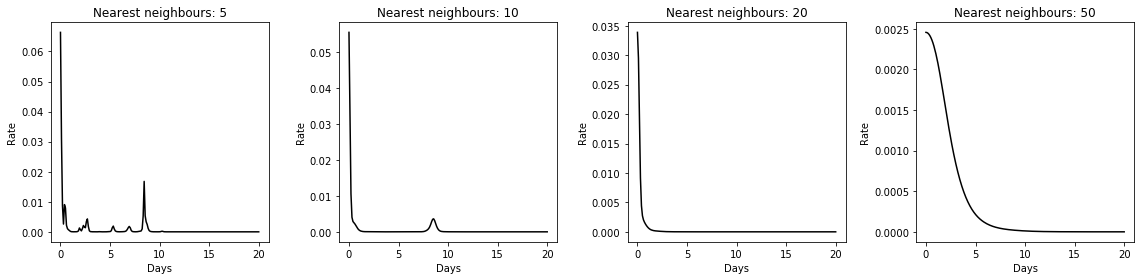

In [33]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))

for ax, bw in zip(axes, models):
    model = models[bw]

    x = np.linspace(0, 20, 200)
    x = x * (trainer.time_unit / np.timedelta64(1,"D"))
    ax.plot(x, model.trigger_func(x) * model.theta, color="black")
    ax.set(xlabel="Days", ylabel="Rate", title="Nearest neighbours: {}".format(bw))
    
fig.tight_layout()
#fig.savefig("../grid_kde_by_nn.pdf")

# Other regions of chicago

Using other years of data is interesting...

In [34]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [35]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

In [36]:
bandwidths = [0.05, 0.1, 1, 2]

models = {}
for side in sides:
    grid, points = load(side)

    models[side] = {}
    for bw in bandwidths:
        trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(bw))
        trainer.data = points
        models[side][bw] = trainer.train(datetime.datetime(2017,1,1), iterations=50)

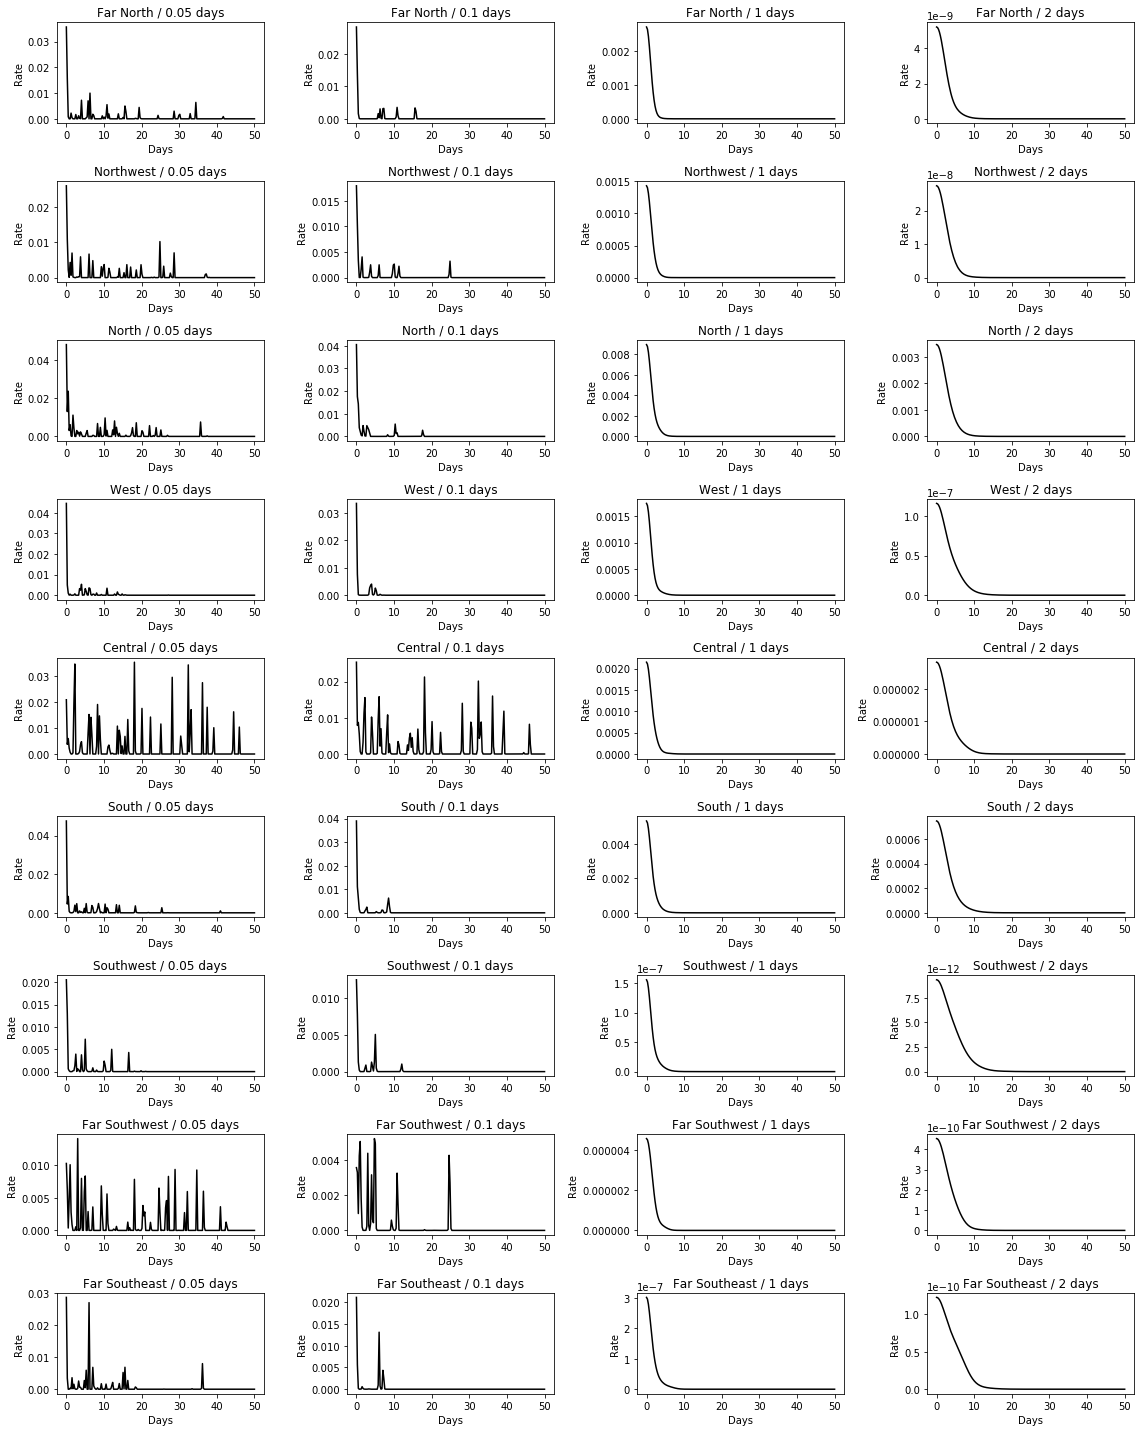

In [37]:
fig, axes = plt.subplots(ncols=4, nrows=len(sides), figsize=(16,20))

for side, axe in zip(sides, axes):
    for ax, bw in zip(axe, models[side]):
        model = models[side][bw]

        x = np.linspace(0, 50, 200)
        x = x * (trainer.time_unit / np.timedelta64(1,"D"))
        ax.plot(x, model.trigger_func(x) * model.theta, color="black")
        ax.set(xlabel="Days", ylabel="Rate", title="{} / {} days".format(side, bw))
    
fig.tight_layout()